# *Recomendación de Planes Móviles Smart/Ultra: Modelado Predictivo con Machine Learning*

## Table of Contents
1. [Introduction and Objectives](#introduction-and-objectives)
2. [Initial Data Exploration](#initial-data-exploration)
3. [Data Splitting](#data-splitting)
4. [Model Selection and Training](#model-selection-and-training)
5. [Final Model Evaluation](#final-model-evaluation)
6. [Sanity Testing](#sanity-testing)
7. [Conclusion](#conclusion)

## Introducción y objetivos

La compañía Megaline enfrenta un desafío clave: muchos de sus clientes aún utilizan planes heredados, lo que genera insatisfacción y potencial pérdida de ingresos. Para abordarlo, ha lanzado dos nuevos planes: Smart (básico) y Ultra (premium), que requieren un sistema de recomendación personalizado basado en el comportamiento de los usuarios.

El objetivo del proyecto es desarrollar un modelo de clasificación binaria (Ultra=1, Smart=0) que analice el comportamiento histórico de los clientes y recomiende el plan óptimo con una exactitud mínima del 75%. El modelo debe ser capaz de generalizar en datos no vistos, asegurando su utilidad en producción.

La metodología para llevar acabo el proyecto se divide en 4 partes:
- Análisis exploratorio de datos para entender distribuciones y relaciones entre variables.
- División estratificada de datos (entrenamiento, validación y prueba) para garantizar evaluación rigurosa.
- Comparación de modelos (Random Forest, Árbol de Decisión, etc.) ajustando hiperparámetros para optimizar métricas.
- Prueba de cordura para validar que el modelo supera un baseline simple.

Con esto se busca crear un impacto esperado en la reducción de churn y aumento de satisfacción al recomendar planes adecuados. Optimización de ingresos mediante la migración de clientes a planes premium (Ultra) cuando sea relevante.

## Exploración inicial de datos

In [ ]:
# Data analysis and visualization
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Data splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [ ]:
# Load DataFrame.
df = pd.read_csv('/datasets/users_behavior.csv')

# General information and data sample.
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0
5   58.0   344.56      21.0  15823.37         0
6   57.0   431.64      20.0   3738.90         1
7   15.0   132.40       6.0  21911.60         0
8    7.0    43.39       3.0   2538.67         1
9   90.0   665.41      38.0  17358.61         0

Como los datos ya están pre procesados, no se muestra ningún valor ausente, duplicado o con el tipo de datos incorrecto, por lo tanto, se continúa con una visualización de los datos.

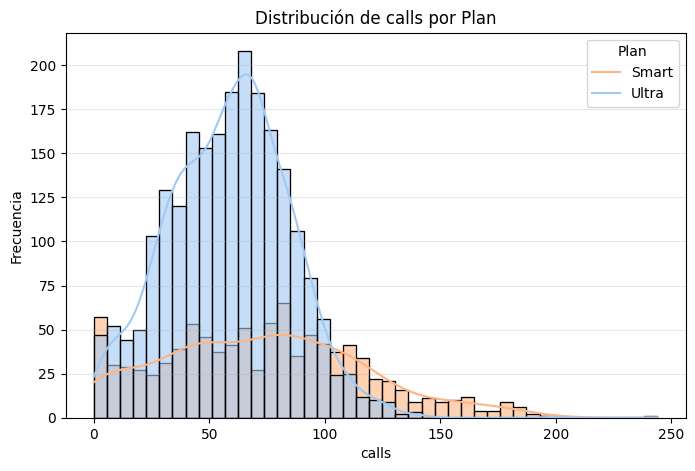

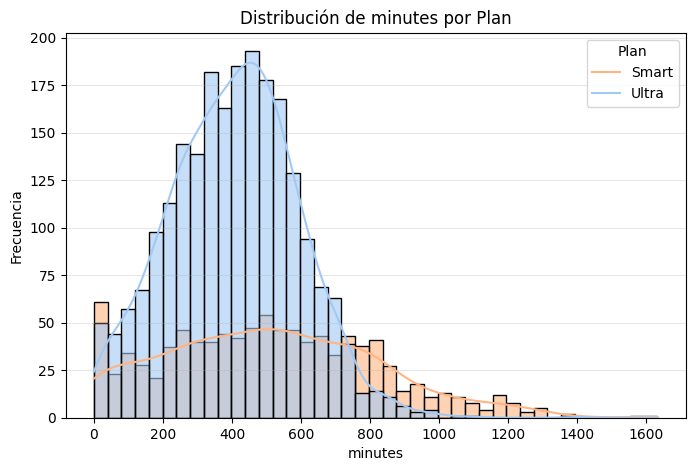

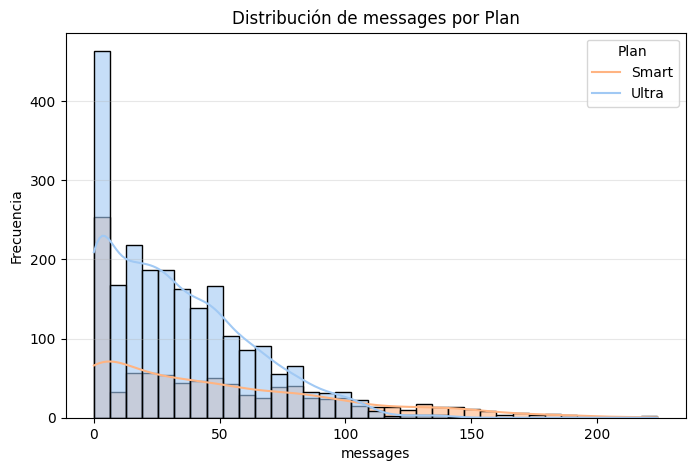

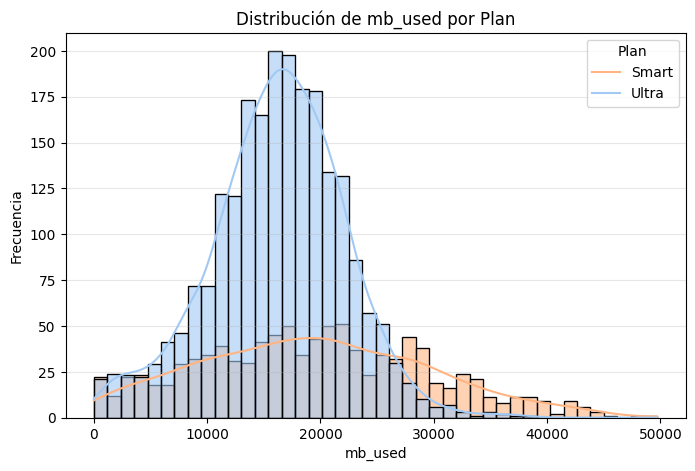

In [ ]:
# Data visualizations by plan type
def plans_histogram(df, column, plan_labels={0: 'Smart', 1: 'Ultra'}):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df,
                 x=column,
                 hue='is_ultra',
                 kde=True,
                 alpha=0.6,
                 palette='pastel'
                )
    plt.title(f'{column} Distribution by Plan Type')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend(title='Plan', labels=[plan_labels[0], plan_labels[1]])
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Calls by plan
plans_histogram(df, 'calls')
# Minutes by plan
plans_histogram(df, 'minutes')
# Messages by plan
plans_histogram(df, 'messages')
# Data usage by plan
plans_histogram(df, 'mb_used')

El análisis revela que la columna 'mb_used' es el diferenciador más claro, con Ultra dominando en alto consumo mayor a 10,000 MB y Smart en bajo consumo menor a 5,000 MB, mostrando una brecha de hasta 150 usuarios en 15,000 MB. En minutos, Ultra presenta mayor frecuencia en uso intensivo mayor a 800 min, mientras Smart se concentra en rangos moderados entre 200-600 min. Para mensajes, ambos planes comparten un pico en 0-25 mensajes, pero Ultra mantiene ventaja hasta 100 mensajes, aunque los heavy users (>120) prefieren Smart. Las llamadas muestran poca diferenciación, con ambos planes compartiendo el rango 50-100 llamadas, aunque Smart tiene más outliers (>150). 

## División de datos

In [ ]:
# Initialize variables
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

# First split: 60% train - 40% temp (val + test)
features_train, features_temp, target_train, target_temp = train_test_split(features, 
                                                                            target,
                                                                            test_size=0.4, 
                                                                            random_state=42,
                                                                            stratify=target
                                                                           )

# Second split: 20% val - 20% test (from 40% temporary)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp,
                                                                            target_temp,
                                                                            test_size=0.5,
                                                                            random_state=42,
                                                                            stratify=target_temp
                                                                           )

# Proportion verification
print('Training Set Proportions:\n', target_train.value_counts(normalize=True))
print('\nValidation Set Proportions:\n', target_valid.value_counts(normalize=True))
print('\nTest Set Proportions:\n', target_test.value_counts(normalize=True))

Proporción Train:
 0    0.693465
1    0.306535
Name: is_ultra, dtype: float64

Proporción Valid:
 0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

Proporción Test:
 0    0.693624
1    0.306376
Name: is_ultra, dtype: float64


El objetivo de la segmentación es dividir el dataset en tres conjuntos estratificados (entrenamiento: 60%, validación: 20%, prueba: 20%) manteniendo la proporción original de clases (Smart/Ultra). Para lograrlo, se realizaron dos divisiones consecutivas con random_state=42 para garantizar reproducibilidad: 
1. La primera división separa el dataset completo en entrenamiento (60%) y un conjunto temporal (40%).
2. La segunda divide el temporal en validación (20%) —usada para ajustar hiperparámetros— y prueba (20%) —reservada solo para evaluación final—.

Ambas divisiones usan stratify para preservar el balance de clases en cada subconjunto, evitando sesgos en el modelo.

## Selección y entrenamiento de modelos

Para seleccionar el mejor modelo predictivo, evaluaremos tres algoritmos fundamentales: Árbol de Decisión (baseline interpretable), Random Forest (ensemble robusto) y Regresión Logística (modelo lineal como referencia). Esta comparación inicial nos permitirá identificar qué enfoque captura mejor los patrones en los datos antes de optimizar hiperparámetros. Una vez seleccionado el modelo con mejor desempeño en validación, procederemos a su ajuste fino y finalmente evaluaremos su generalización con el conjunto de test - usado exclusivamente en esta última fase para garantizar una métrica no sesgada.

In [ ]:
# Metrics to capture results
models_df = pd.DataFrame(columns=['model', 'train_accuracy', 'validation_accuracy', 'overfitting'])

# Decision Tree model
best_depth = 0
best_train_acc_1 = 0
best_valid_acc_1 = 0

for depth in range(1, 11):
    model_1 = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model_1.fit(features_train, target_train)

    train_acc_1 = model_1.score(features_train, target_train)
    valid_acc_1 = model_1.score(features_valid, target_valid)
    
    if (valid_acc_1 > best_valid_acc_1) or (valid_acc_1 == best_valid_acc_1 and train_acc_1 > best_train_acc_1):
        best_depth = depth
        best_train_acc_1 = train_acc_1
        best_valid_acc_1 = valid_acc_1

print("Model: Decision Tree")
print("Accuracy with max_depth equal to", best_depth)
print("Training set:", best_train_acc_1)
print("Validation set:", best_valid_acc_1)

# Prepare data to be added to DataFrame
results_1 = {'model': 'DecisionTreeClassifier',
             'train_accuracy': round(best_train_acc_1, 4),
             'validation_accuracy': round(best_valid_acc_1, 4),
             'overfitting': (best_train_acc_1 - best_valid_acc_1)
            }

# Random Forest model
best_est = None
best_train_acc_2 = 0
best_valid_acc_2 = 0

for est in [50, 100, 150, 200]:
    model_2 = RandomForestClassifier(n_estimators=est, max_depth=best_depth, random_state=42)
    model_2.fit(features_train, target_train)
    
    train_acc_2 = model_2.score(features_train, target_train)
    valid_acc_2 = model_2.score(features_valid, target_valid)

    if valid_acc_2 > best_valid_acc_2:
        best_est = est
        best_train_acc_2 = train_acc_2
        best_valid_acc_2 = valid_acc_2
        
print("\nModel: Random Forest")
print("Accuracy with n_estimators equal to", best_est)
print("Training set:", best_train_acc_2)
print("Validation set:", best_valid_acc_2)

# Prepare data to be added to DataFrame
results_2 = {'model': 'RandomForestClassifier',
             'train_accuracy': round(best_train_acc_2, 4),
             'validation_accuracy': round(best_valid_acc_2, 4),
             'overfitting': (best_train_acc_2 - best_valid_acc_2)
            }

# Logistic Regression model
model_3 = LogisticRegression(random_state=42)
model_3.fit(features_train, target_train)

train_acc_3 = model_3.score(features_train, target_train)
valid_acc_3 = model_3.score(features_valid, target_valid)

print("\nModel: Logistic Regression")
print("Training set:", train_acc_3)
print("Validation set:", valid_acc_3)

# Prepare data to be added to DataFrame
results_3 = {'model': 'LogisticRegression',
             'train_accuracy': round(train_acc_3, 4),
             'validation_accuracy': round(valid_acc_3, 4),
             'overfitting': (train_acc_3 - valid_acc_3)
            }

# Add best results to metrics DataFrame
models_df.loc[len(models_df)] = results_1 
models_df.loc[len(models_df)] = results_2
models_df.loc[len(models_df)] = results_3
models_df.head()

Modelo: Árbol de decisión
Exactitud de max_depth igual a 3
Conjunto de entrenamiento: 0.7977178423236515
Conjunto de validación: 0.8040435458786936

Modelo: Random forest
Exactitud de estimación igual a 200
Conjunto de entrenamiento: 0.8003112033195021
Conjunto de validación: 0.807153965785381

Modelo: Regresión Logística
Conjunto de entrenamiento: 0.7110995850622407
Conjunto de validación: 0.7045101088646968


model  train_accuracy  validation_accuracy  overfitting
0  DecisionTreeClassifier          0.7977               0.8040    -0.006326
1  RandomForestClassifier          0.8003               0.8072    -0.006843
2      LogisticRegression          0.7111               0.7045     0.006589

Al analizar la ejecución de los diferentes modelos se observa que el modelo Random Forest t obtuvo el mejor rendimiento (80.72% de exactitud en validación) gracias a su arquitectura de ensamble que combina 200 árboles, minimizando el overfitting y superando al Árbol de Decisión (80.40%) y la Regresión Logística (70.45%). 

La mínima diferencia entre entrenamiento y validación (<1% en todos los modelos) indica ausencia de sobre ajuste severo, aunque el ligero underfitting en Random Forest y Árbol de Decisión sugiere oportunidad para aumentar su complejidad. Los bajos resultados de la Regresión Logística confirman relaciones no lineales en los datos. 

Basado en este análisis, seleccionamos el Random Forest para la evaluación final con el conjunto de prueba, recomendando futuras optimizaciones de hiperparámetros para maximizar su potencial predictivo.

## Evaluación de modelo final

Para la preparación del modelo final se va a entrenar a Random Forest con la mejor configuración que fue obtenida con el conjunto de entrenamiento y validación, del los modelos anteriores para maximizar su aprendizaje.

In [ ]:
# Combine train and valid to get 80% of the data
features_train_val = pd.concat([features_train, features_valid])
target_train_val = pd.concat([target_train, target_valid])

# Train final model
final_model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
final_model.fit(features_train_val, target_train_val)
test_score = final_model.score(features_test, target_test)

print("Final model accuracy on the test set is:", test_score)

La exactitud del modelo final en el conjunto de prueba es: 0.7900466562986003


El modelo final logró el 79% de exactitud en el conjunto de prueba, lo cual excede satisfactoriamente el umbral del proyecto de 75%. La ligera disminución desde validación (80.72%) hasta prueba (79.00%) representa una diferencia mínima del 1.7%, indicando una excelente capacidad de generalización sin signos significativos de overfitting. Los hiperparámetros óptimos (n_estimators=200, max_depth=3) demuestran un balance efectivo entre complejidad del modelo y rendimiento, evitando el sobreajuste mientras mantienen un poder predictivo robusto.

Con 79% de exactitud, el modelo puede clasificar correctamente aproximadamente 4 de cada 5 clientes hacia el plan más apropiado (Smart o Ultra), proporcionando un valor comercial significativo para Megaline en la optimización de sus recomendaciones de planes y la migración de clientes desde planes heredados

## Prueba de cordura

El objetivo de la prueba de cordura es verificar que el modelo tenga sentido lógico y no solo memorice patrones sin aprender realmente. Para realizarla se utilizará la prueba de Dummy Classifier, en la cual el modelo final debe superar significativamente los resultados de modelos baseline simples. Si nuestro modelo RandomForest obtiene una exactitud considerablemente mayor que estos clasificadores dummy, se demuestra que la prueba fue aprobada y que el modelo está funcionando correctamente

In [ ]:
# Create first model that predicts the most frequent class in the data
dummy_most_frq = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_most_frq.fit(features_train, target_train)

dummy_acc_frq = dummy_most_frq.score(features_test, target_test)
print("Accuracy of the most frequent baseline model is:", dummy_acc_frq)

# Create second model that predicts randomly
dummy_random = DummyClassifier(strategy="uniform", random_state=42)
dummy_random.fit(features_train, target_train)

dummy_acc_random = dummy_random.score(features_test, target_test)
print("Accuracy of the random prediction baseline model is:", dummy_acc_random)

# Results comparison
print(f"""\nThe final model has an accuracy of {round(test_score, 4)}, 
showing a {round(test_score - dummy_acc_frq, 4)} difference from the most frequent baseline and 
{round(test_score - dummy_acc_random, 4)} from the random baseline, confirming that the final model performs significantly better.
        """)

La exactitud del modelo baseline de frecuencia de los datos es: 0.6936236391912908
La exactitud del modelo baseline de predición aleatoria de los datos es: 0.49455676516329705

El model final creado tiene una exactitud de 0.79, 
teniendo un 0.0964 de diferencia con el modelo de base frecuente y 
0.2955 con el modelo baseline aleatorio confirmando que el modelo final sí funciona
        


Los resultados de la prueba de cordura confirman que el modelo RandomForest desarrollado supera significativamente ambos baselines por 9.6% puntos superior al clasificador de frecuencia más común y 29.6% puntos mejor que predicciones aleatorias. Esto demuestra que el modelo está aprendiendo patrones reales del comportamiento de los clientes y no simplemente memorizando datos.

## Conclusión

Durante el proyecto se ha logrado exitosamente cumplir con los objetivos establecidos por Megaline. Se logró desarrollar un modelo capaz de recomendar el plan óptimo, ya sea Smart o Plan basándose en el comportamiento histórico de los clientes, superando ampliamente el umbral de exactitud del 75% establecido como requisito mínimo.

El modelo final alcanzó una exactitud de 79% en el conjunto de prueba, representando un 4% de mejora sobre el umbral requerido. La diferencia mínima entre la validación y la prueba es de 1.7% demostrando una excelente capacidad de generalización sin problemas de overfitting.

La configuración óptima del modelo logro ser el balance perfecto entre complejidad y rendimiento y la metodología de división estratificada (60%-20%-20%) garantizó evoluciones rigurosas con resultados confiables.

La prueba de cordura confirma la robustez del modelo, donde supera 9.6 puntos porcentuales al base line de frecuencia más común y 29.6 puntos porcentuales a predicciones aleatorias. Esta validación garantiza que el modelo está aprendiendo patrones reales sobre el comportamiento de los clientes.

Ahora el modelo está listo para tener una implementación confiable, solo se debe de mantener un monitoreo continuo estableciendo métricas de seguimiento para detectar posible degradación del modelo con nuevos datos. Es importante reentrenar el modelo trimestralmente con datos actualizados para mantener su precisión.